## Libraries:

In [10]:
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

## Load Data:

In [11]:
# Load the Excel file
file_path = 'KPMG_VI_New_raw_data_update_final.xlsx'
transactions = pd.read_excel(file_path, sheet_name='Transactions',header=1)
new_customers = pd.read_excel(file_path, sheet_name='NewCustomerList', header=1)
customer_demographics = pd.read_excel(file_path, sheet_name='CustomerDemographic', header=1)
customer_address = pd.read_excel(file_path, sheet_name='CustomerAddress', header=1)


## Understand Data Distribution:

In [12]:
# Summary statistics
print('transactions')
print(transactions.describe())
print('new_customers')
print(new_customers.describe())
print('customer_demographics')
print(customer_demographics.describe())
print('customer_address')
print(customer_address.describe())

# Check for missing values
print('transactions')
print(transactions.isnull().sum())
print('new_customers')
print(new_customers.isnull().sum())
print('customer_demographics')
print(customer_demographics.isnull().sum())
print('customer_address')
print(customer_address.isnull().sum())


transactions
       transaction_id   product_id   customer_id            transaction_date  \
count    20000.000000  20000.00000  20000.000000                       20000   
mean     10000.500000     45.36465   1738.246050  2017-07-01 14:08:05.280000   
min          1.000000      0.00000      1.000000         2017-01-01 00:00:00   
25%       5000.750000     18.00000    857.750000         2017-04-01 00:00:00   
50%      10000.500000     44.00000   1736.000000         2017-07-03 00:00:00   
75%      15000.250000     72.00000   2613.000000         2017-10-02 00:00:00   
max      20000.000000    100.00000   5034.000000         2017-12-30 00:00:00   
std       5773.647028     30.75359   1011.951046                         NaN   

       online_order    list_price  standard_cost  product_first_sold_date  
count  19640.000000  20000.000000   19803.000000             19803.000000  
mean       0.500458   1107.829449     556.046951             38199.776549  
min        0.000000     12.010000     

In [13]:
# Check column names of each DataFrame
print(transactions.columns)
print(new_customers.columns)
print(customer_demographics.columns)
print(customer_address.columns)

Index(['transaction_id', 'product_id', 'customer_id', 'transaction_date',
       'online_order', 'order_status', 'brand', 'product_line',
       'product_class', 'product_size', 'list_price', 'standard_cost',
       'product_first_sold_date'],
      dtype='object')
Index(['first_name', 'last_name', 'gender',
       'past_3_years_bike_related_purchases', 'DOB', 'job_title',
       'job_industry_category', 'wealth_segment', 'deceased_indicator',
       'owns_car', 'tenure', 'address', 'postcode', 'state', 'country',
       'property_valuation', 'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18',
       'Unnamed: 19', 'Unnamed: 20', 'Rank', 'Value'],
      dtype='object')
Index(['customer_id', 'first_name', 'last_name', 'gender',
       'past_3_years_bike_related_purchases', 'DOB', 'job_title',
       'job_industry_category', 'wealth_segment', 'deceased_indicator',
       'default', 'owns_car', 'tenure'],
      dtype='object')
Index(['customer_id', 'address', 'postcode', 'state', 'country',
    

## Data Cleaning:

In [14]:
# Remove columns with 'Unnamed: i' where 'i' is a number
new_customers = new_customers.loc[:, ~new_customers.columns.str.contains('^Unnamed')]
customer_demographics = customer_demographics.loc[:, ~customer_demographics.columns.str.contains('^Unnamed')]
customer_address = customer_address.loc[:, ~customer_address.columns.str.contains('^Unnamed')]

# Handle missing values for numeric columns
transactions.fillna(transactions.mean(numeric_only=True), inplace=True)
new_customers.fillna(new_customers.mean(numeric_only=True), inplace=True)

# Handle missing values for non-numeric columns if needed
transactions.fillna('', inplace=True)
new_customers.fillna('', inplace=True)

# Drop rows with missing DOB in customer_demographics
customer_demographics.dropna(subset=['DOB'], inplace=True)

# Fill missing values in customer_address
customer_address.fillna('', inplace=True)


In [15]:
# Check column names of each DataFrame
print(transactions.columns)
print(new_customers.columns)
print(customer_demographics.columns)
print(customer_address.columns)

Index(['transaction_id', 'product_id', 'customer_id', 'transaction_date',
       'online_order', 'order_status', 'brand', 'product_line',
       'product_class', 'product_size', 'list_price', 'standard_cost',
       'product_first_sold_date'],
      dtype='object')
Index(['first_name', 'last_name', 'gender',
       'past_3_years_bike_related_purchases', 'DOB', 'job_title',
       'job_industry_category', 'wealth_segment', 'deceased_indicator',
       'owns_car', 'tenure', 'address', 'postcode', 'state', 'country',
       'property_valuation', 'Rank', 'Value'],
      dtype='object')
Index(['customer_id', 'first_name', 'last_name', 'gender',
       'past_3_years_bike_related_purchases', 'DOB', 'job_title',
       'job_industry_category', 'wealth_segment', 'deceased_indicator',
       'default', 'owns_car', 'tenure'],
      dtype='object')
Index(['customer_id', 'address', 'postcode', 'state', 'country',
       'property_valuation'],
      dtype='object')


# Phase 2: Model Development

## Feature Engineering:

In [16]:
# Convert DOB to age
customer_demographics['DOB'] = pd.to_datetime(customer_demographics['DOB'])
customer_demographics['Age'] = customer_demographics['DOB'].apply(lambda x: (datetime.now() - x).days // 365)

# Merge datasets
customer_data = customer_demographics.merge(customer_address, on='customer_id').merge(transactions, on='customer_id')

# Example: Creating additional features
customer_data['TotalSpend'] = customer_data['list_price'] * customer_data['standard_cost']

# Create a dummy 'high_value_customer' column (for example purposes, customers with TotalSpend > 1000 are high value)
customer_data['high_value_customer'] = customer_data['TotalSpend'] > 1000


## Data Transformation:

In [17]:
# Identify categorical and numerical columns
categorical_cols = ['gender', 'state', 'job_industry_category']
numerical_cols = ['Age', 'TotalSpend', 'past_3_years_bike_related_purchases', 'property_valuation']

# Data transformation pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(), categorical_cols)
    ]
)


## Model Selection and Training:

In [18]:
# Define features and target
X = customer_data[['Age', 'TotalSpend', 'gender', 'state', 'job_industry_category', 'past_3_years_bike_related_purchases', 'property_valuation']]
y = customer_data['high_value_customer']  # This column now exists

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a pipeline
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Train the model
model_pipeline.fit(X_train, y_train)

# Validate the model
y_pred = model_pipeline.predict(X_val)


## Results Interpretation:

In [19]:


# Classification report
print(classification_report(y_val, y_pred))

# Confusion matrix
print(confusion_matrix(y_val, y_pred))


              precision    recall  f1-score   support

       False       1.00      1.00      1.00        44
        True       1.00      1.00      1.00      3861

    accuracy                           1.00      3905
   macro avg       1.00      1.00      1.00      3905
weighted avg       1.00      1.00      1.00      3905

[[  44    0]
 [   0 3861]]


## Visualization:

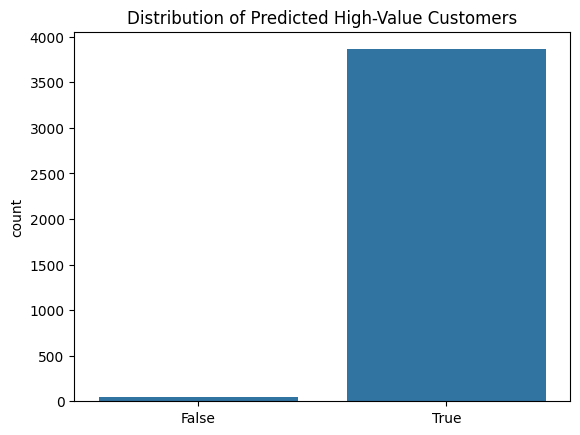

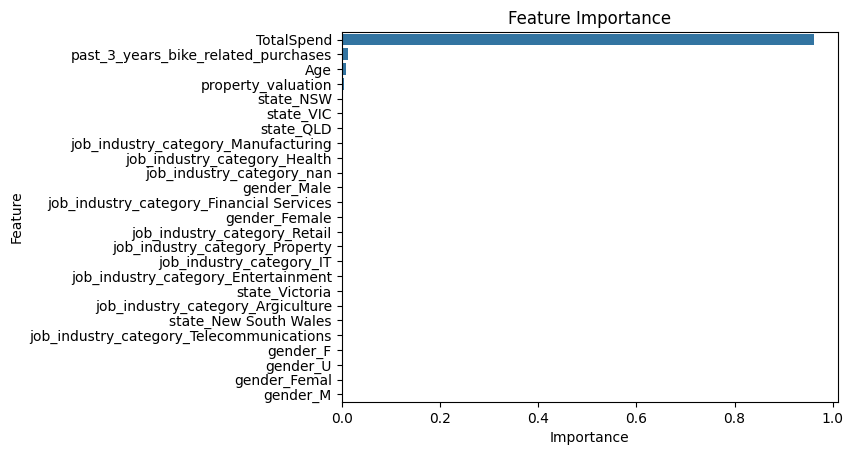

In [20]:


# Example: Visualizing the distribution of predicted high-value customers
sns.countplot(x=y_pred)
plt.title('Distribution of Predicted High-Value Customers')
plt.show()

# Example: Feature importance
feature_importances = model_pipeline.named_steps['classifier'].feature_importances_
features = numerical_cols + list(model_pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out())
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df.sort_values(by='Importance', ascending=False, inplace=True)

sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance')
plt.show()
